In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys

# ensure project root (one level up) is on PATH
ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)

## Import the model

In [3]:
from utils.import_models import ModelImporter
players_model = ModelImporter().download_player_model()

Model downloaded to /home/bbrzyski/.cache/kagglehub/models/blaku03/player-detection/pyTorch/player_detectionv1_1/1


## Load the video generator and generate tracks

In [4]:
from trackers.game_tracker import GameTracker
from utils.video_utils import read_video, save_video

video_path = "../sample_data/B1606b0e6_1 (91).mp4"
output_path = "../output_videos/output_video.avi"
os.makedirs(os.path.dirname(output_path), exist_ok=True)

frame_generator = read_video(video_path)
tracks_generator =  GameTracker(players_model).get_detections_from_frames(frame_generator)

## Sanity check on the first frame


0: 544x960 1 goalkeeper, 21 players, 1 referee, 32.3ms
1: 544x960 1 ball, 20 players, 2 referees, 32.3ms
2: 544x960 1 ball, 20 players, 2 referees, 32.3ms
3: 544x960 1 ball, 21 players, 2 referees, 32.3ms
4: 544x960 1 ball, 21 players, 2 referees, 32.3ms
5: 544x960 21 players, 3 referees, 32.3ms
6: 544x960 1 ball, 20 players, 2 referees, 32.3ms
7: 544x960 1 ball, 21 players, 4 referees, 32.3ms
8: 544x960 1 goalkeeper, 22 players, 1 referee, 32.3ms
9: 544x960 1 ball, 1 goalkeeper, 22 players, 32.3ms

0: 544x960 21 players, 2 referees, 33.2ms
1: 544x960 22 players, 2 referees, 33.2ms
2: 544x960 20 players, 2 referees, 33.2ms
3: 544x960 1 ball, 20 players, 2 referees, 33.2ms
4: 544x960 1 ball, 20 players, 2 referees, 33.2ms
5: 544x960 20 players, 2 referees, 33.2ms
6: 544x960 1 ball, 20 players, 2 referees, 33.2ms
7: 544x960 1 ball, 20 players, 2 referees, 33.2ms
8: 544x960 1 ball, 20 players, 2 referees, 33.2ms
9: 544x960 1 ball, 22 players, 2 referees, 33.2ms
10: 544x960 22 players, 2 

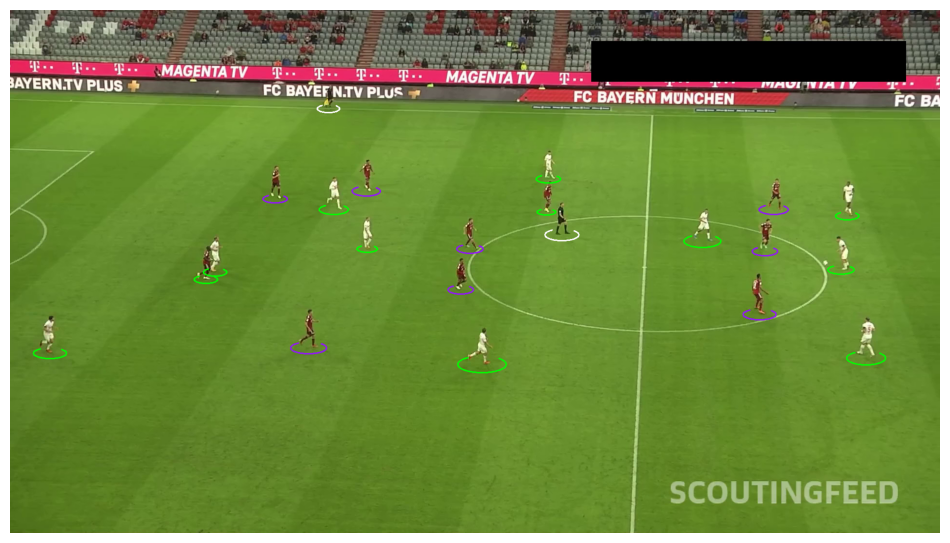

In [5]:
from annotators.player_annotator import PlayersAnnotator
from utils.notebook_utils import show_image
import itertools

frame_generator = read_video(video_path)
tracks_generator =  GameTracker(players_model).get_detections_from_frames(frame_generator)

first_frame = next(frame_generator)

tracks_gen1, tracks_gen2 = itertools.tee(tracks_generator)
first_players_tracks = next(tracks_gen1)

tracks_generator = tracks_gen2

annotated_sample_image = PlayersAnnotator.annotate_frame(first_frame, first_players_tracks)
show_image(annotated_sample_image)

## Annotate the video

In [6]:
frame_generator = read_video(video_path)
annotated_frames_generator = PlayersAnnotator.annotate_video(frame_generator, tracks_generator)
save_video(annotated_frames_generator, output_path)

Speed: 3.0ms preprocess, 33.2ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 960)

0: 544x960 1 ball, 20 players, 2 referees, 33.3ms
1: 544x960 1 ball, 24 players, 2 referees, 33.3ms
2: 544x960 1 ball, 21 players, 2 referees, 33.3ms
3: 544x960 1 ball, 21 players, 2 referees, 33.3ms
4: 544x960 1 ball, 22 players, 1 referee, 33.3ms
5: 544x960 1 ball, 21 players, 1 referee, 33.3ms
6: 544x960 1 ball, 22 players, 2 referees, 33.3ms
7: 544x960 20 players, 2 referees, 33.3ms
8: 544x960 1 ball, 21 players, 2 referees, 33.3ms
9: 544x960 22 players, 2 referees, 33.3ms
10: 544x960 1 ball, 22 players, 2 referees, 33.3ms
11: 544x960 1 ball, 22 players, 2 referees, 33.3ms
12: 544x960 1 ball, 21 players, 2 referees, 33.3ms
13: 544x960 21 players, 2 referees, 33.3ms
14: 544x960 21 players, 2 referees, 33.3ms
15: 544x960 22 players, 2 referees, 33.3ms
16: 544x960 1 ball, 21 players, 2 referees, 33.3ms
17: 544x960 1 ball, 21 players, 2 referees, 33.3ms
18: 544x960 1 ball, 21 players, 2 re

749